In [1]:
import os
import sys
import scipy.io
import scipy.misc
import imageio
import matplotlib.pyplot as plt
from PIL import Image
from nst_utils import *
import numpy as np
import tensorflow as tf

%matplotlib inline

In [2]:
# for content cost 
def compute_content_cost(a_C, a_G):
    m, n_H, n_W, n_C = a_G.get_shape().as_list()

    a_C_unrolled = tf.reshape(a_C, shape=[m, n_H, n_W, n_C])
    a_G_unrolled = tf.reshape(a_G, shape=[m, n_H, n_W, n_C])
    
    J_content = tf.reduce_sum(tf.square(a_C_unrolled - a_G_unrolled)) / (4 * n_H * n_W * n_C)
    
    return J_content

In [3]:
def gram_matrix(A):
    GA = tf.matmul(A, tf.transpose(A))    
    return GA

In [4]:
# for layer style cost
def compute_layer_style_cost(a_S, a_G):
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    a_S = tf.transpose(tf.reshape(a_S, [n_H*n_W, n_C]))
    a_G = tf.transpose(tf.reshape(a_G, [n_H*n_W, n_C]))

    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    J_style_layer = (1./(4 * n_C**2 * (n_H*n_W)**2)) * tf.reduce_sum(tf.pow((GS - GG), 2))

    return J_style_layer

In [5]:
# weights for different layers
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

In [6]:
# for style cost
def compute_style_cost(model, STYLE_LAYERS):
    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:
        out = model[layer_name]
        a_S = sess.run(out)
        a_G = out
        J_style_layer = compute_layer_style_cost(a_S, a_G)
        J_style += coeff * J_style_layer

    return J_style

In [7]:
# total cost
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    J = alpha * J_content + beta * J_style
    return J

In [8]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

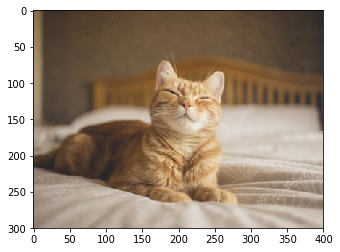

In [31]:
# loading the content image and normalizing it
content_image = imageio.imread("images/cat1.jpg")
plt.imshow(content_image)
content_image = reshape_and_normalize_image(content_image)

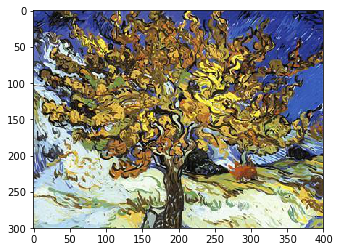

In [32]:
# loading the style image and normalizing it
style_image = imageio.imread("images/mul.jpg")
plt.imshow(style_image)
style_image = reshape_and_normalize_image(style_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


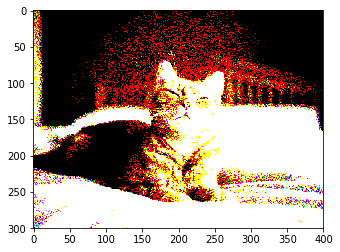

In [33]:
# generating a noise image from the content image
generated_image = generate_noise_image(content_image)
plt.imshow(generated_image[0])

In [34]:
# load the model
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")
#print(model)

In [35]:
# assign the content image to be the input of the model.  
sess.run(model['input'].assign(content_image))

# the output tensor of layer conv4_2
out = model['conv4_2']

# hidden layer activation
a_C = sess.run(out)
a_G = out

# the content cost
J_content = compute_content_cost(a_C, a_G)

In [36]:
# assign the input of the model to be the "style" image 
sess.run(model['input'].assign(style_image))

# compute the style cost
J_style = compute_style_cost(model, STYLE_LAYERS)

In [37]:
# compute the total cost
J = total_cost(J_content, J_style, alpha = 10, beta = 40)

In [38]:
optimizer = tf.train.AdamOptimizer(2.0)

train_step = optimizer.minimize(J)

In [39]:
def model_nn(sess, input_image, num_iterations = 400):
    
    # initialize global variables
    sess.run(tf.global_variables_initializer())
    
    # run the noisy input image (initial generated image) through the model
    sess.run(model['input'].assign(input_image))
    
    for i in range(num_iterations):
    
        # run the session on the train_step to minimize the total cost
        sess.run(train_step)

        # compute the generated image by running the session on the current model['input']
        generated_image = sess.run(model['input'])
        
        # displaying the total cost, content cost and style cost after every 20 iterations
        if i%20 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            
            # save current generated image in the "/output" directory
            # save_image("f4/" + str(i) + ".png", generated_image)
    
    # save last generated image
    save_image('output/generated_image9.jpg', generated_image)
    
    return generated_image

In [40]:
model_nn(sess, generated_image)

Iteration 0 :
total cost = 14002166000.0
content cost = 5662.4067
style cost = 350052740.0
Iteration 20 :
total cost = 2291654000.0
content cost = 20895.268
style cost = 57286124.0
Iteration 40 :
total cost = 732022900.0
content cost = 22539.834
style cost = 18294938.0
Iteration 60 :
total cost = 393046370.0
content cost = 23050.645
style cost = 9820397.0
Iteration 80 :
total cost = 246380960.0
content cost = 23304.213
style cost = 6153698.0
Iteration 100 :
total cost = 169342800.0
content cost = 23458.232
style cost = 4227705.5
Iteration 120 :
total cost = 126038640.0
content cost = 23555.299
style cost = 3145077.2
Iteration 140 :
total cost = 100319450.0
content cost = 23646.889
style cost = 2502074.5
Iteration 160 :
total cost = 83554460.0
content cost = 23719.773
style cost = 2082931.6
Iteration 180 :
total cost = 71656260.0
content cost = 23786.225
style cost = 1785459.8
Iteration 200 :
total cost = 62709876.0
content cost = 23844.016
style cost = 1561785.9
Iteration 220 :
total c

array([[[[  41.02972  ,  -57.723877 ,   20.525623 ],
         [ -22.184227 ,  -29.413067 ,   52.342304 ],
         [ -59.397507 ,  -34.60888  ,   55.901253 ],
         ...,
         [  52.949066 ,   31.91585  ,  -30.573088 ],
         [  16.921608 ,   46.07759  ,  -52.4248   ],
         [ 128.08858  ,  121.431625 ,  -24.847437 ]],

        [[  10.669799 ,  -70.053894 ,   16.268085 ],
         [ -51.086838 ,  -51.33142  ,  -36.27669  ],
         [ -43.032227 ,  -41.769672 ,  -20.403214 ],
         ...,
         [ -86.001625 ,  -14.928998 ,  -38.24773  ],
         [ -82.58215  ,  -76.644165 ,  -64.37854  ],
         [ -91.59388  ,  -55.013775 ,  -80.60293  ]],

        [[  57.757664 ,  -12.417818 ,   20.948471 ],
         [  58.27738  ,  -28.17877  ,   83.23579  ],
         [  41.712914 ,  -23.149334 ,   97.60344  ],
         ...,
         [ -59.442997 ,   -5.533259 ,  -10.498648 ],
         [-103.254166 ,  -26.659622 ,  -63.84976  ],
         [ -72.01533  ,  -11.131858 ,  -43.8525   ]],

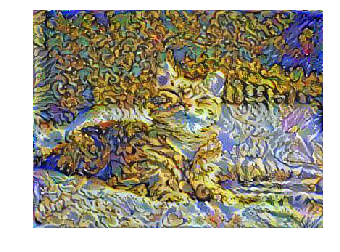

In [42]:
i = imageio.imread('output/generated_image9.jpg')
plt.axis('off')
plt.imshow(i)